In [1]:
# Dependencies
from scipy.stats import linregress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Import data into pandas df's

In [2]:
#Import data as pandas DF's
Education_2021_df = pd.read_csv("Resources/2021_Education_Postcode.csv")
Income_2021_df = pd.read_csv("Resources/2021_Income_Postcode.csv")
VehicleCount_2021_df = pd.read_csv("Resources/2021_VehicleCount_Postcode.csv")
FuelType_2021_df = pd.read_csv("Resources/FuelType_Postcode.csv")

Define functions for plotting and cleaning of tables

In [3]:
def create_scatter(df, y_variable, x_variable, colour):

    x_values = df[x_variable]
    y_values = df[y_variable]
    
    ymin = df[y_variable].min()
    xmin = df[x_variable].min()

    ymax = df[y_variable].max()
    xmax = df[x_variable].max()

    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(slope) + "x + s" + str(round(intercept,2))

    plt.scatter(
        x_values,
        y_values,
        color = colour,
        marker = 'o',
        s = 50,
        edgecolors = 'black')

    plt.plot(x_values, regress_values, "r-", linewidth = 1)

    plt.xlabel(x_variable)
    plt.ylabel("Percentage of EV's in postcode")
    plt.suptitle(f"The r-value is: {rvalue}", fontsize = 8, x = 0.2, y = 0.95)
    plt.annotate(line_eq, xy=(0.5, 1.05), fontsize =8, color = "red",
            xycoords='axes fraction', textcoords='axes fraction')

    plt.show()


In [4]:
def reshape_df(df):
    return df.pivot_table(index = ['Vehicle_type', 'Postcode'], 
                          columns = 'Fuel_type', 
                          values = 'Count').reset_index().rename_axis(None, axis=1)

In [5]:
def clean_headers(df):
    df.columns = df.columns.str.replace(" ", "_")
    return df

Initial data cleaning

In [6]:
#Clean Headers
Education_2021_df = clean_headers(Education_2021_df)
Income_2021_df = clean_headers(Income_2021_df)
VehicleCount_2021_df = clean_headers(VehicleCount_2021_df)
FuelType_2021_df = clean_headers(FuelType_2021_df)

In [7]:
FuelType_2021_df = reshape_df(FuelType_2021_df)

In [8]:
FuelType_2021_df = FuelType_2021_df[FuelType_2021_df["Vehicle_type"] != "Total"]
FuelType_2021_df = FuelType_2021_df[FuelType_2021_df["Postcode"] != "Total"]

c:\Users\joshm\anaconda3\envs\PythonData\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Merge DFs so that Education, income, vehicle count, fuel type are in 1 df on postcode handle different postcodes that arent present in all datasets

In [9]:
Education_2021_df['Postcode'] = Education_2021_df['Postcode'].astype(int)
data_education_income_2021 = pd.merge(Education_2021_df, Income_2021_df, how="inner", on= ["Postcode", "Postcode"])
data_complete_2021 = pd.merge(data_education_income_2021, VehicleCount_2021_df ,how="inner", on= ["Postcode", "Postcode"])
data_complete_2021 = data_complete_2021.drop(['State','Total_y', 'Total'], axis=1)

Remove data for "Not Stated or Not Applicable" and subtract from Total column

In [10]:
Education_2021_df["Total"] = Education_2021_df["Total"] - (Education_2021_df["Not_stated"] + Education_2021_df["Not_applicable"])
Education_2021_df = Education_2021_df.drop(columns=["Not_stated", "Not_applicable"])


In [11]:
Income_2021_df["Total"] = Income_2021_df["Total"] - (Income_2021_df["Not_stated"] + Income_2021_df["Not_applicable"])
Income_2021_df = Income_2021_df.drop(columns=["Not_stated", "Not_applicable"])

Create DF's with normalised values (percentage of total)

In [12]:
Education_2021_Normalized = Education_2021_df.copy()
for col in Education_2021_Normalized.columns[2:-1]:
    Education_2021_Normalized[col] = Education_2021_Normalized[col] / Education_2021_Normalized["Total"] * 100
Education_2021_Normalized = Education_2021_Normalized.round(2)

In [13]:
FuelType_2021_Normalized = FuelType_2021_df.copy()
for col in FuelType_2021_Normalized.columns[2:-1]:
    FuelType_2021_Normalized[col] = FuelType_2021_Normalized[col] / FuelType_2021_Normalized["Total"] * 100
FuelType_2021_Normalized = FuelType_2021_Normalized.round(2)

In [14]:
Income_2021_Normalized = Income_2021_df.copy()
for col in Income_2021_Normalized.columns[2:-1]:
    Income_2021_Normalized[col] = Income_2021_Normalized[col] / Income_2021_Normalized["Total"] * 100
Income_2021_Normalized = Income_2021_Normalized.round(2)

Create criteria for ranking suburbs based on income and education.

In [15]:
#Calculate an "Income score" for each 
def calculate_income_score(row):
    values = row[2:-2].values
    weights = [0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
    weighted_sum = sum([value * weight for value, weight in zip(values, weights)])
    
    return weighted_sum

Income_2021_Normalized['Income_Score'] = Income_2021_Normalized.apply(calculate_income_score, axis=1)

In [16]:
Education_2021_Scored = Education_2021_Normalized
#Apply a multiplier based on education score to new columns
Education_2021_Scored["Postgraduate_Degree_Score"] = Education_2021_Scored["Postgraduate_Degree_Level"].apply(lambda x: x*7)
Education_2021_Scored["Graduate_Diploma_and_Graduate_Certificate_Score"] = Education_2021_Scored["Graduate_Diploma_and_Graduate_Certificate_Level"].apply(lambda x: x*6)
Education_2021_Scored["Bachelor_Degree_Score"] = Education_2021_Scored["Bachelor_Degree_Level"].apply(lambda x: x*5)
Education_2021_Scored["Advanced_Diploma_and_Diploma_Score"] = Education_2021_Scored["Advanced_Diploma_and_Diploma_Level"].apply(lambda x: x*4)
Education_2021_Scored["Certificate_III_&_IV_Level_Score"] = Education_2021_Scored["Certificate_III_&_IV_Level"].apply(lambda x: x*3)
Education_2021_Scored["Certificate_I_&_II_Level_Score"] = Education_2021_Scored["Certificate_I_&_II_Level"].apply(lambda x: x*2)
Education_2021_Scored["Secondary_Education_-_Years_10_and_above_Score"] = Education_2021_Scored["Secondary_Education_-_Years_10_and_above"].apply(lambda x: x*2)
Education_2021_Scored["Secondary_Education_-_Years_9_and_below_Score"] = Education_2021_Scored["Secondary_Education_-_Years_9_and_below"].apply(lambda x: x*1)
#Drop unneeeded columns
Education_2021_Scored = Education_2021_Scored.drop(["Postgraduate_Degree_Level", "Graduate_Diploma_and_Graduate_Certificate_Level", "Bachelor_Degree_Level", "Advanced_Diploma_and_Diploma_Level", "Certificate_III_&_IV_Level", "Certificate_I_&_II_Level", "Secondary_Education_-_Years_10_and_above", "Secondary_Education_-_Years_9_and_below"], axis=1)
#Create a column in df with summed education scores
Education_Score_List = ["Postgraduate_Degree_Score", "Graduate_Diploma_and_Graduate_Certificate_Score", "Bachelor_Degree_Score", "Advanced_Diploma_and_Diploma_Score", "Certificate_III_&_IV_Level_Score", "Certificate_I_&_II_Level_Score", "Secondary_Education_-_Years_10_and_above_Score", "Secondary_Education_-_Years_9_and_below_Score"]
Education_2021_Scored["Education_Score"] = Education_2021_Scored[Education_Score_List].sum(axis=1)


Merge and clean data

In [17]:
Income_Fueltype_2021 = pd.merge(FuelType_2021_Normalized, Income_2021_Normalized, on='Postcode')
Income_Fueltype_2021 = Income_Fueltype_2021[Income_Fueltype_2021['Total_x'] != 0]
Income_Fueltype_2021 = Income_Fueltype_2021[Income_Fueltype_2021['Vehicle_type'] == "Passenger Vehicles"]

In [18]:
Education_Fueltype_2021 = pd.merge(FuelType_2021_Normalized, Education_2021_Scored, on = "Postcode")
Education_Fueltype_2021 = Education_Fueltype_2021[Education_Fueltype_2021['Total_x'] != 0]

#Select only Passenger Vehicles
Education_Fueltype_2021 = Education_Fueltype_2021[Education_Fueltype_2021['Vehicle_type'] == "Passenger Vehicles"]


In [19]:
# read in and add electoraterating values for each postcode. Remove duplicates and keep the first non-null value for electoraterating
# Outer Metro, Inner Metro and provincial are grouped for this purpose as "Metro", and Rural is left as Rural. Null values will be dropped for the purpose of plotting.
Metro_Rural_Postcode = pd.read_csv('Resources/ElectorateRating_Postcode.csv')
Metro_Rural_Postcode = Metro_Rural_Postcode.drop_duplicates().groupby('Postcode', as_index=False).first()

In [20]:
#Merge Metro/Rural values with Income and Education dfs
Education_Fueltype_2021 = pd.merge(Education_Fueltype_2021, Metro_Rural_Postcode, on = "Postcode")
Income_Fueltype_2021 = pd.merge(Income_Fueltype_2021, Metro_Rural_Postcode, on='Postcode')

In [21]:
#Drop Rows where Metro_Rural is NaN
Education_Fueltype_2021.dropna(subset=["Metro_Rural"], inplace=True)
Income_Fueltype_2021.dropna(subset=["Metro_Rural"], inplace=True)

Data Visualisation

In [22]:
Income_Metro = Income_Fueltype_2021[Income_Fueltype_2021['Metro_Rural'] == 'Metro']
Education_Metro = Education_Fueltype_2021[Education_Fueltype_2021['Metro_Rural'] == 'Metro']
Income_Rural= Income_Fueltype_2021[Income_Fueltype_2021['Metro_Rural'] == 'Rural']
Education_Rural = Education_Fueltype_2021[Education_Fueltype_2021['Metro_Rural'] == 'Rural']

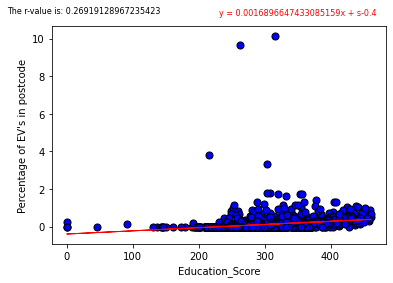

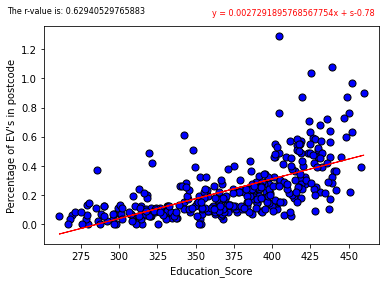

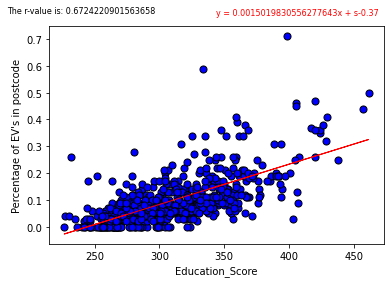

In [23]:
create_scatter(Education_Fueltype_2021, "Electric", "Education_Score", "blue")
create_scatter(Education_Metro.query("Total_x > 5000"), "Electric", "Education_Score", "blue")
create_scatter(Education_Rural.query("Total_x > 5000"), "Electric", "Education_Score", "blue")

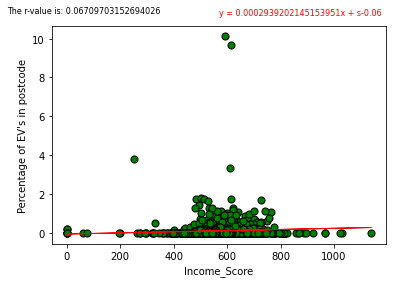

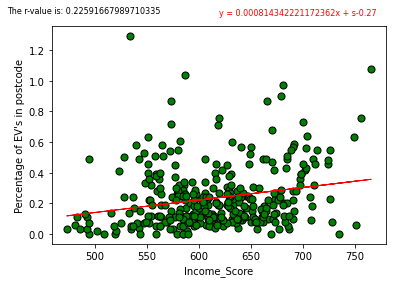

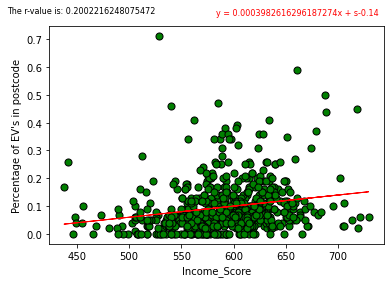

In [24]:
create_scatter(Income_Fueltype_2021, "Electric", "Income_Score", "green")
create_scatter(Income_Metro.query("Total_x > 5000"), "Electric", "Income_Score", "green")
create_scatter(Income_Rural.query("Total_x > 5000"), "Electric", "Income_Score", "green")